# I. Mirror number classification
### 1) MLP (multilayer perceptron) network

*Based on: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/*

Here we implement our first ML model for the basic task of classifying the number of mirrors in the system, based on the interference pattern. We start with a simple deep neural network - an MLP - which consists of several fully connected layers. 

In [1]:
# necessary imports

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt

The input data is in the form of a CSV file, where each row has numbers separated by commas. The first value signifies the number of mirrors present in the system; subsequent numbers are the values of total transmittance for equally spaced wavenumbers k. The number of k values is constant through all the rows and depends on the generated data - the more k values, the more dense the probing of the k-space.

Let us load the dataset and visualize some interference pattern.

In [2]:
dataset = loadtxt('data50_2.csv', delimiter=',', skiprows=1)

# number of k samples
k_samples = 50

# number of classes (of mirror numbers)
num_classes = 8

# list of class labels
classes = [f'{class_id}' for class_id in range(3, 11)]

# mirror numbers (the correct classes) in the first column
y = dataset[:,0]

# convenient to have the classes starting from 0, so just subtract 3 from every y
y -= 3

# transmittance values
X = dataset[:,1:]

This dataset we normalize by the maximal values of each sample.

In [3]:
X = X / np.max(X, axis = 1, keepdims = True)

Example plot:

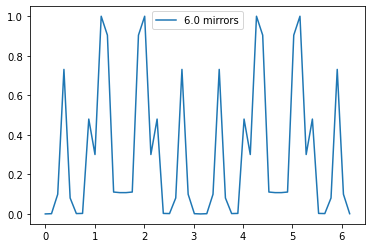

In [4]:
# k-space for plotting
kmin = 0
kmax = 2 * np.pi
ks = np.linspace(kmin, kmax, k_samples, endpoint = False)

which_row = 42200

plt.figure()
plt.plot(ks, X[which_row], label=f'{y[which_row]+3} mirrors')
plt.legend(loc='best')
plt.show()

We will now split the dataset randomly into the training and test parts, borrowing a function from the scikit-learn package.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, 
                                                    test_size = 0.25,
                                                    random_state = 42)

# the 'stratify = y' argument ensures that the training and testing sets contain the same proportion of each class
# we especially need to watch out for this for the lowest number of mirrors 
# which forms a tiny proportion of the whole dataset:

print('Proportion of 3-mirror elements in the testing set:', list(y_test).count(0) / len(y_test))
print('Proportion of 3-mirror elements in the testing set:', list(y_train).count(0) / len(y_train))

Proportion of 3-mirror elements in the testing set: 0.0018492804028186927
Proportion of 3-mirror elements in the testing set: 0.00184928440263788


Checks out. Let us build the network now (with the sizes of hidden layers chosen arbitrarily).

In [6]:
# Define the model
model = Sequential()
model.add(Dense(24, input_dim=k_samples, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='sigmoid'))

# The last layer consists of 8 nodes as we generated the data for 3 to 10 mirrors.

We shall define metrics to gauge the performance of our model using a useful function from the sklearn module. To have it evaluated after each epoch of the training, we will wrap it in a Keras callback. This callback will evaluate the classification report and log it to a log dictionary.

In [7]:
from sklearn.metrics import classification_report

classification_report_log_dict = {f'{class_id}' : {'precision': [], 'recall': [], 'f1-score': []} 
                                  for class_id in range(3, 11)} | {'accuracy': [], 
                                        'macro avg': {'precision': [], 'recall': [], 'f1-score': []},
                                        'weighted avg': {'precision': [], 'recall': [], 'f1-score': []}}

class PerformanceEvaluationCallback(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test
        
    def on_epoch_end(self, epoch, logs=None):
        print('Evaluating the model...', end = ' ')
        y_pred = self.model.predict(self.x_test, verbose=0, batch_size = len(self.x_test))
        y_pred = np.argmax(y_pred, axis = 1)
        report = classification_report(self.y_test, y_pred, 
                              target_names = ['3','4','5','6','7','8','9','10'], output_dict = True)
        for class_id in classes + ['macro avg', 'weighted avg']:
            classification_report_log_dict[class_id]['precision'].append(report[class_id]['precision'])
            classification_report_log_dict[class_id]['recall'].append(report[class_id]['recall'])
            classification_report_log_dict[class_id]['f1-score'].append(report[class_id]['f1-score'])
        
        classification_report_log_dict['accuracy'].append(report['accuracy'])
        print(f"Accuracy: {report['accuracy']}")
        
        
performance_callback = PerformanceEvaluationCallback(X_test, y_test)

Now we compile.

In [8]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', run_eagerly = 1)

Set necessary prerequisites and train, using the testing data for validation.

In [9]:
epochs = 500
batch_size = 64

callbacks = [
    performance_callback,
    
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/500
7225/7225 [==============================] - 85s 12ms/step - loss: 1.3541 - val_loss: 1.2376
Evaluating the model... Accuracy: 0.4360538302814799
Epoch 2/500
7225/7225 [==============================] - 82s 11ms/step - loss: 1.1621 - val_loss: 1.0935
Evaluating the model... Accuracy: 0.49731367688853706
Epoch 3/500
7225/7225 [==============================] - 83s 11ms/step - loss: 1.0456 - val_loss: 0.9905
Evaluating the model... Accuracy: 0.550462644535863
Epoch 4/500
7225/7225 [==============================] - 86s 12ms/step - loss: 0.9738 - val_loss: 0.9398
Evaluating the model... Accuracy: 0.5752105584177947
Epoch 5/500
7225/7225 [==============================] - 83s 11ms/step - loss: 0.9221 - val_loss: 0.9239
Evaluating the model... Accuracy: 0.5782926924224925
Epoch 6/500
7225/7225 [==============================] - 87s 12ms/step - loss: 0.8809 - val_loss: 0.8634
Evaluating the model... Accuracy: 0.5970450445773907
Epoch 7/500
7225/7225 [=============================

7225/7225 [==============================] - 100s 14ms/step - loss: 0.5043 - val_loss: 0.6071
Evaluating the model... Accuracy: 0.7138222354880154
Epoch 53/500
7225/7225 [==============================] - 99s 14ms/step - loss: 0.5011 - val_loss: 0.5170
Evaluating the model... Accuracy: 0.7543247206613286
Epoch 54/500
7225/7225 [==============================] - 104s 14ms/step - loss: 0.4981 - val_loss: 0.4694
Evaluating the model... Accuracy: 0.7736221238823209
Epoch 55/500
7225/7225 [==============================] - 101s 14ms/step - loss: 0.4960 - val_loss: 0.5030
Evaluating the model... Accuracy: 0.7660627846918515
Epoch 56/500
7225/7225 [==============================] - 101s 14ms/step - loss: 0.4908 - val_loss: 0.4946
Evaluating the model... Accuracy: 0.7596259911494089
Epoch 57/500
7225/7225 [==============================] - 101s 14ms/step - loss: 0.4878 - val_loss: 0.5008
Evaluating the model... Accuracy: 0.7563427073465098
Epoch 58/500
7225/7225 [==============================

7225/7225 [==============================] - 95s 13ms/step - loss: 0.3692 - val_loss: 0.3544
Evaluating the model... Accuracy: 0.8153250191416743
Epoch 104/500
7225/7225 [==============================] - 95s 13ms/step - loss: 0.3676 - val_loss: 0.4104
Evaluating the model... Accuracy: 0.7839326732159311
Epoch 105/500
7225/7225 [==============================] - 96s 13ms/step - loss: 0.3648 - val_loss: 0.3831
Evaluating the model... Accuracy: 0.7980261364963598
Epoch 106/500
7225/7225 [==============================] - 96s 13ms/step - loss: 0.3644 - val_loss: 0.4153
Evaluating the model... Accuracy: 0.7655047562194219
Epoch 107/500
7225/7225 [==============================] - 96s 13ms/step - loss: 0.3622 - val_loss: 0.5407
Evaluating the model... Accuracy: 0.7219331144477464
Epoch 108/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.3613 - val_loss: 0.3548
Evaluating the model... Accuracy: 0.8093164800083056
Epoch 109/500
7225/7225 [=============================

7225/7225 [==============================] - 95s 13ms/step - loss: 0.2934 - val_loss: 0.2458
Evaluating the model... Accuracy: 0.8576832734209741
Epoch 155/500
7225/7225 [==============================] - 95s 13ms/step - loss: 0.2918 - val_loss: 0.2602
Evaluating the model... Accuracy: 0.857806558781162
Epoch 156/500
7225/7225 [==============================] - 95s 13ms/step - loss: 0.2900 - val_loss: 0.2653
Evaluating the model... Accuracy: 0.8322151134874184
Epoch 157/500
7225/7225 [==============================] - 95s 13ms/step - loss: 0.2887 - val_loss: 0.3321
Evaluating the model... Accuracy: 0.8103352064056477
Epoch 158/500
7225/7225 [==============================] - 95s 13ms/step - loss: 0.2888 - val_loss: 0.3260
Evaluating the model... Accuracy: 0.8175506443282246
Epoch 159/500
7225/7225 [==============================] - 95s 13ms/step - loss: 0.2859 - val_loss: 0.2953
Evaluating the model... Accuracy: 0.8192506845581842
Epoch 160/500
7225/7225 [==============================

7225/7225 [==============================] - 97s 13ms/step - loss: 0.2010 - val_loss: 0.2158
Evaluating the model... Accuracy: 0.8446215139442231
Epoch 206/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1991 - val_loss: 0.2373
Evaluating the model... Accuracy: 0.8376980676641966
Epoch 207/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.2007 - val_loss: 0.2139
Evaluating the model... Accuracy: 0.8484433601100484
Epoch 208/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1993 - val_loss: 0.1989
Evaluating the model... Accuracy: 0.859616906964974
Epoch 209/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1977 - val_loss: 0.1758
Evaluating the model... Accuracy: 0.8637112786638462
Epoch 210/500
7225/7225 [==============================] - 103s 14ms/step - loss: 0.1974 - val_loss: 0.1859
Evaluating the model... Accuracy: 0.8611222860999
Epoch 211/500
7225/7225 [==============================] 

7225/7225 [==============================] - 95s 13ms/step - loss: 0.1770 - val_loss: 0.1568
Evaluating the model... Accuracy: 0.8522587175727059
Epoch 257/500
7225/7225 [==============================] - 96s 13ms/step - loss: 0.1777 - val_loss: 0.1541
Evaluating the model... Accuracy: 0.8746317660952282
Epoch 258/500
7225/7225 [==============================] - 96s 13ms/step - loss: 0.1769 - val_loss: 0.2196
Evaluating the model... Accuracy: 0.8420974084119548
Epoch 259/500
7225/7225 [==============================] - 96s 13ms/step - loss: 0.1754 - val_loss: 0.1891
Evaluating the model... Accuracy: 0.8558534591276588
Epoch 260/500
7225/7225 [==============================] - 96s 13ms/step - loss: 0.1756 - val_loss: 0.1906
Evaluating the model... Accuracy: 0.846315065471015
Epoch 261/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1757 - val_loss: 0.1969
Evaluating the model... Accuracy: 0.8409553966544246
Epoch 262/500
7225/7225 [==============================

7225/7225 [==============================] - 97s 13ms/step - loss: 0.1307 - val_loss: 0.1307
Evaluating the model... Accuracy: 0.8701934931284634
Epoch 308/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1301 - val_loss: 0.1406
Evaluating the model... Accuracy: 0.8611482409125713
Epoch 309/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1305 - val_loss: 0.1638
Evaluating the model... Accuracy: 0.8545167862750951
Epoch 310/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1308 - val_loss: 0.1255
Evaluating the model... Accuracy: 0.8722309459231478
Epoch 311/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1296 - val_loss: 0.1373
Evaluating the model... Accuracy: 0.8563271344589071
Epoch 312/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1295 - val_loss: 0.1451
Evaluating the model... Accuracy: 0.8578195361874976
Epoch 313/500
7225/7225 [=============================

7225/7225 [==============================] - 50s 7ms/step - loss: 0.1228 - val_loss: 0.1110
Evaluating the model... Accuracy: 0.8753065912246778
Epoch 359/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1222 - val_loss: 0.1939
Evaluating the model... Accuracy: 0.8341617244377538
Epoch 360/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1228 - val_loss: 0.1157
Evaluating the model... Accuracy: 0.8646196971073361
Epoch 361/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1075 - val_loss: 0.1069
Evaluating the model... Accuracy: 0.8667999013717118
Epoch 362/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1078 - val_loss: 0.1080
Evaluating the model... Accuracy: 0.8715106998715236
Epoch 363/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1080 - val_loss: 0.1132
Evaluating the model... Accuracy: 0.8643277054647858
Epoch 364/500
7225/7225 [==============================] - 4

Evaluating the model... Accuracy: 0.8616868032754974
Epoch 410/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1011 - val_loss: 0.1171
Evaluating the model... Accuracy: 0.8616413823533229
Epoch 411/500
7225/7225 [==============================] - 50s 7ms/step - loss: 0.1007 - val_loss: 0.1599
Evaluating the model... Accuracy: 0.843265374982156
Epoch 412/500
7225/7225 [==============================] - 50s 7ms/step - loss: 0.1005 - val_loss: 0.1030
Evaluating the model... Accuracy: 0.8662808051182891
Epoch 413/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1006 - val_loss: 0.1041
Evaluating the model... Accuracy: 0.8701480722062889
Epoch 414/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1006 - val_loss: 0.1025
Evaluating the model... Accuracy: 0.8668193674812152
Epoch 415/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1002 - val_loss: 0.0954
Evaluating the model... Accuracy: 0.86541131889

7225/7225 [==============================] - 61s 8ms/step - loss: 0.0979 - val_loss: 0.1032
Evaluating the model... Accuracy: 0.8595455312301283
Epoch 462/500
7225/7225 [==============================] - 62s 9ms/step - loss: 0.0980 - val_loss: 0.1013
Evaluating the model... Accuracy: 0.8711343550877921
Epoch 463/500
7225/7225 [==============================] - 61s 8ms/step - loss: 0.0974 - val_loss: 0.0935
Evaluating the model... Accuracy: 0.8752287267866644
Epoch 464/500
7225/7225 [==============================] - 61s 8ms/step - loss: 0.0982 - val_loss: 0.0971
Evaluating the model... Accuracy: 0.8626601087506651
Epoch 465/500
7225/7225 [==============================] - 50s 7ms/step - loss: 0.0979 - val_loss: 0.0891
Evaluating the model... Accuracy: 0.8727435534734028
Epoch 466/500
7225/7225 [==============================] - 55s 8ms/step - loss: 0.0978 - val_loss: 0.1207
Evaluating the model... Accuracy: 0.8524923108867462
Epoch 467/500
7225/7225 [==============================] - 6

The best model is saved and can be recovered with the following line:

In [10]:
#model = keras.models.load_model("best_model.h5")

Let us now plot the history of training.

In [11]:
import matplotlib.cm as cm
cmap = cm.get_cmap('jet')
colors = [cmap(i/7.) for i in range(8)]

First, the overall accuracy and averages of the class-dependent metrics: precision, recall and the F1 score.

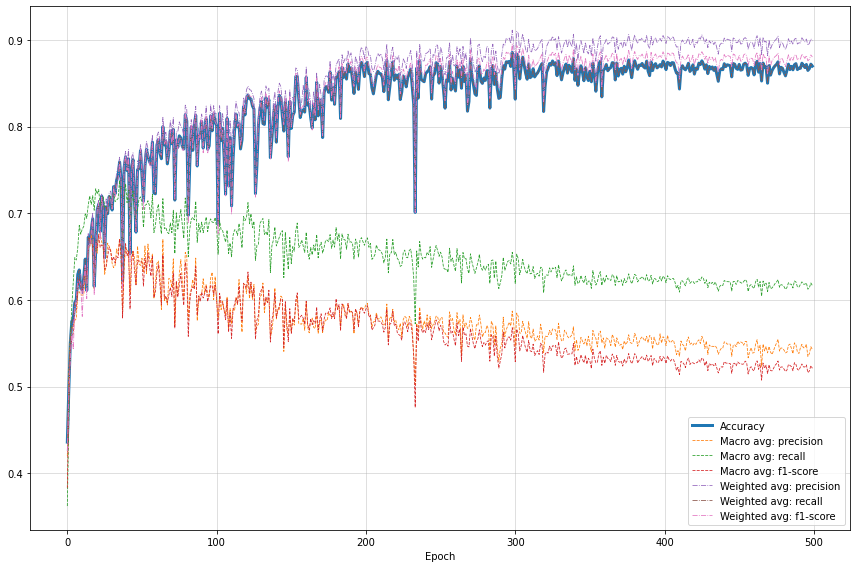

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

ax1.set_xlabel("Epoch")

ax1.plot(classification_report_log_dict['accuracy'], label = 'Accuracy', linewidth = 3)

ax1.plot(classification_report_log_dict['macro avg']['precision'], 
         label = 'Macro avg: precision', linestyle='--', linewidth = 0.8)
ax1.plot(classification_report_log_dict['macro avg']['recall'], 
         label = 'Macro avg: recall', linestyle='--', linewidth = 0.8)
ax1.plot(classification_report_log_dict['macro avg']['f1-score'], 
         label = 'Macro avg: f1-score', linestyle='--', linewidth = 0.8)

ax1.plot(classification_report_log_dict['weighted avg']['precision'], 
         label = 'Weighted avg: precision', linestyle='-.', linewidth = 0.8)
ax1.plot(classification_report_log_dict['weighted avg']['recall'], 
         label = 'Weighted avg: recall', linestyle='-.', linewidth = 0.8)
ax1.plot(classification_report_log_dict['weighted avg']['f1-score'], 
         label = 'Weighted avg: f1-score', linestyle='-.', linewidth = 0.8)


ax1.legend(loc='best')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

Then precision for each class:

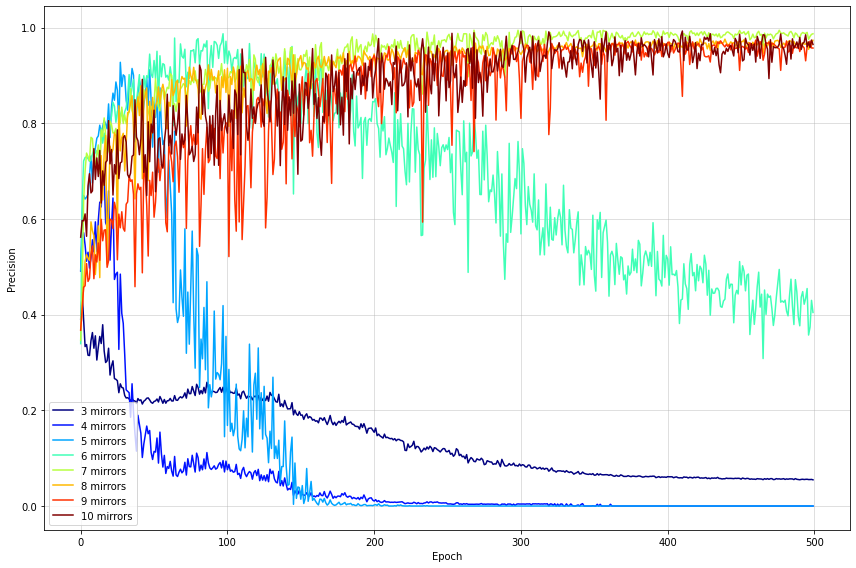

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

metric = "Precision"
ax1.set_ylabel(metric)
ax1.set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    ax1.plot(classification_report_log_dict[class_id]['precision'], 
             label = class_id + ' mirrors', color=col)
    
ax1.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

Recall for each class:

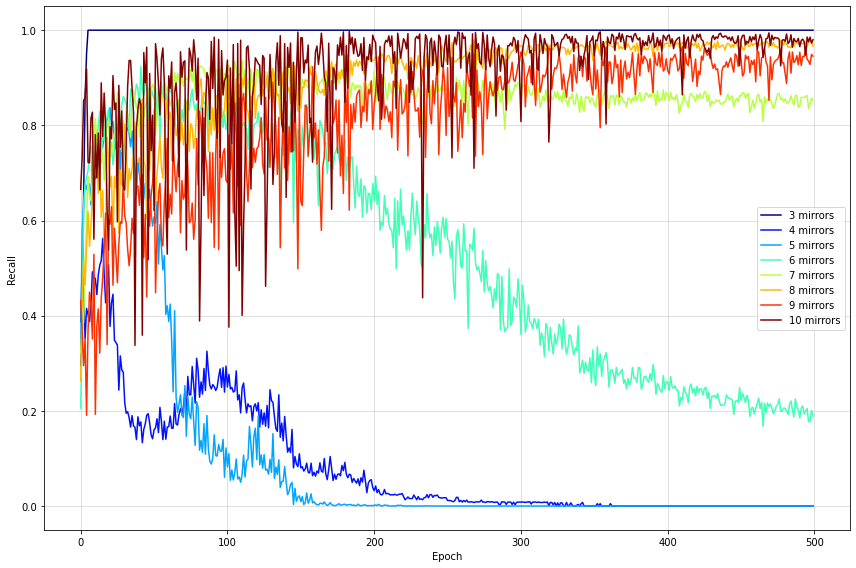

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

metric = "Recall"
ax1.set_ylabel(metric)
ax1.set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    ax1.plot(classification_report_log_dict[class_id]['recall'], 
             label = class_id + ' mirrors', color=col)
    
ax1.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

And the F1 score for each class:

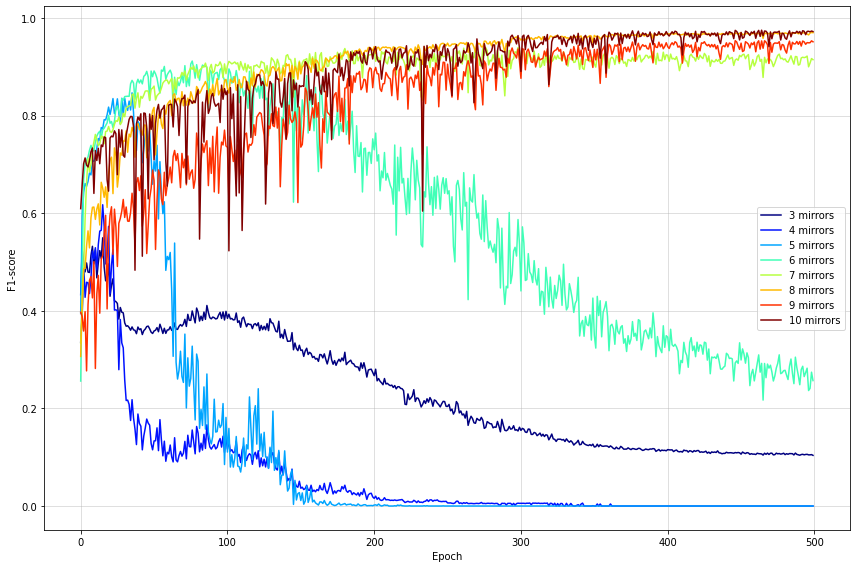

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

metric = "F1-score"
ax1.set_ylabel(metric)
ax1.set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    ax1.plot(classification_report_log_dict[class_id]['f1-score'], 
             label = class_id + ' mirrors', color=col)
    
ax1.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

For completeness and convenience, we also output the final classification report in text form.

In [16]:
y_pred = model.predict(X_test, batch_size=len(X_test), verbose=1)
y_test_check = y_test
y_pred_check = np.argmax(y_pred, axis = 1)
print(classification_report(y_test_check, y_pred_check, target_names = classes))

1/1 [==============================] - 0s 52ms/step
              precision    recall  f1-score   support

           3       0.05      1.00      0.10       285
           4       0.00      0.00      0.00      1211
           5       0.00      0.00      0.00      3876
           6       0.40      0.19      0.26      9690
           7       0.99      0.85      0.91     19380
           8       0.97      0.97      0.97     31493
           9       0.96      0.95      0.95     41990
          10       0.96      0.98      0.97     46189

    accuracy                           0.87    154114
   macro avg       0.54      0.62      0.52    154114
weighted avg       0.90      0.87      0.88    154114



History for future reference:

In [17]:
print(classification_report_log_dict)

{'3': {'precision': [0.39069767441860465, 0.44594594594594594, 0.3891213389121339, 0.3333333333333333, 0.33748443337484435, 0.31526548672566373, 0.31456953642384106, 0.34545454545454546, 0.36259541984732824, 0.3298611111111111, 0.35580524344569286, 0.30513918629550324, 0.3321678321678322, 0.35447761194029853, 0.3396901072705602, 0.37898936170212766, 0.3242320819112628, 0.3, 0.3035143769968051, 0.3298611111111111, 0.2737752161383285, 0.29290853031860226, 0.3035143769968051, 0.26635514018691586, 0.2648698884758364, 0.2619485294117647, 0.23690773067331672, 0.2553763440860215, 0.24782608695652175, 0.24675324675324675, 0.23095623987034036, 0.22583201267828842, 0.22655007949125597, 0.22388059701492538, 0.2197378565921357, 0.22476340694006308, 0.22024729520865532, 0.21956856702619415, 0.2144469525959368, 0.22458628841607564, 0.22058823529411764, 0.2219626168224299, 0.2131637995512341, 0.21906225980015373, 0.22144522144522144, 0.22529644268774704, 0.2260111022997621, 0.22178988326848248, 0.216